In [1]:
import os
import csv

#os.chdir(r'C:\My\x2\180617\_merge')
mypath = os.getcwd()
print(mypath)

D:\_PlayGround\Github\pg\_chaos


In [2]:
infile_name = '20180617.csv'
infile_name = '180617_19-50-00.327.csv'

###### data preview

In [3]:
with open(infile_name, encoding='utf8') as csvf:
    rd = csv.reader(csvf, delimiter=',')
    for idx, line in enumerate(rd):
        print(line)
        
        if idx > 10:
            break

['0', '2018-06-17 195000.327002', '0.060999', '2.448898', '2.550633', '2.465567', '100', '1']
['1', '2018-06-17 195000.327004', '0.060352', '2.448898', '2.549986', '2.46589', '100', '1']
['2', '2018-06-17 195000.327006', '0.059705', '2.448898', '2.549016', '2.46589', '100', '1']
['3', '2018-06-17 195000.327008', '0.059058', '2.448898', '2.547723', '2.466536', '100', '1']
['4', '2018-06-17 195000.327010', '0.058411', '2.449222', '2.548369', '2.467829', '100', '1']
['5', '2018-06-17 195000.327012', '0.057441', '2.449222', '2.548046', '2.468152', '100', '1']
['6', '2018-06-17 195000.327014', '0.057441', '2.449545', '2.547723', '2.468798', '100', '1']
['7', '2018-06-17 195000.327016', '0.056793', '2.449545', '2.547723', '2.469122', '100', '1']
['8', '2018-06-17 195000.327018', '0.056146', '2.450839', '2.547399', '2.469445', '100', '1']
['9', '2018-06-17 195000.327020', '0.055823', '2.45181', '2.547399', '2.469768', '100', '1']
['10', '2018-06-17 195000.327022', '0.054852', '2.452781', '2.5

###### loading data

In [4]:
import pandas as pd
import numpy as np

names = ['idx', 'reg_date', 'y', 'u', 'v', 'w', 'hz', 'ch']
df = pd.read_csv(infile_name, sep=',', names=names)
# df = df.sample(frac=1)  # random sampling

In [5]:
df.shape[0]

25000

###### model - poly reg

In [ ]:
training_set_X_poly_reg
training_set_y

In [233]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


training_set_size = 15000
test_set_size = 10000

training_set_X = df[['silver_u', 'silver_w', 'silver_v']].values.reshape(-1,3)[0:training_set_size, :]
training_set_y = df[['gold']][0:training_set_size].values.reshape(-1, 1) / 5 * 1000

test_set_X = df[['silver_u', 'silver_w', 'silver_v']].values.reshape(-1,3)[training_set_size:(training_set_size+test_set_size), :]
test_set_y = df[['gold']][training_set_size:(training_set_size+test_set_size)].values.reshape(-1, 1) / 5 * 1000

poly = PolynomialFeatures(degree=3)
training_set_X_poly_reg = poly.fit_transform(training_set_X)
test_set_X_poly_reg = poly.fit_transform(test_set_X)

model_poly_reg = LinearRegression()
model_poly_reg.fit(training_set_X_poly_reg, training_set_y)
test_set_pred_poly_reg = model_poly_reg.predict(test_set_X_poly_reg)

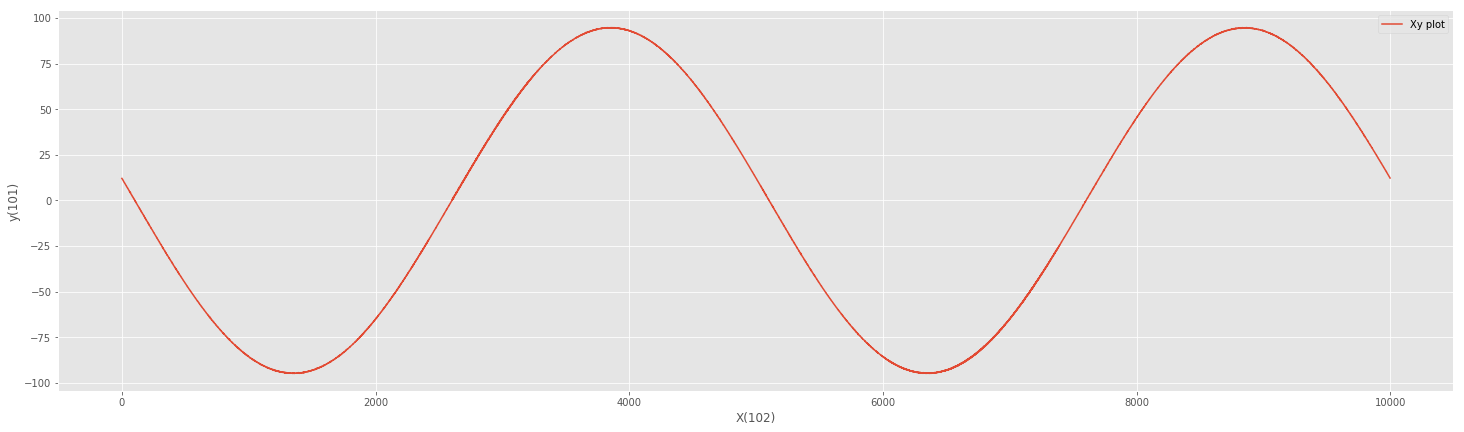

mse: 0.052771906827645286  abs max: 1.1555103274822187  abs avg: 0.18054588759183154


In [234]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt_x = range(len(test_set_X[:, 0]))
plt.plot(plt_x, (test_set_y), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()


print('mse:', mean_squared_error(test_set_y, test_set_pred_poly_reg),
      ' abs max:', np.max(np.abs(test_set_y - test_set_pred_poly_reg)),
      ' abs avg:', np.average(np.abs(test_set_y - test_set_pred_poly_reg)))

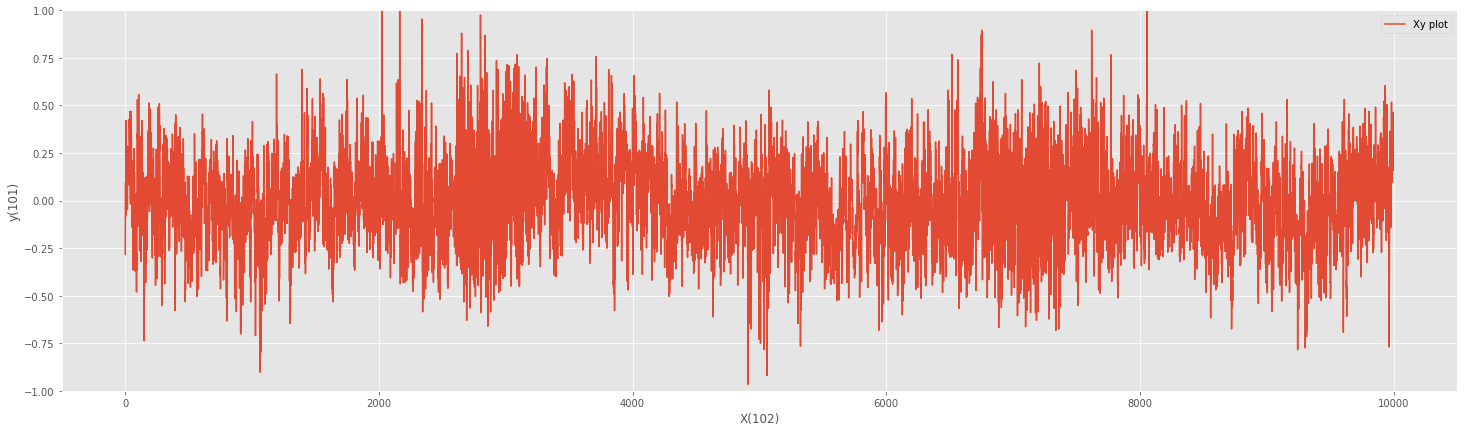

mse: 0.052771906827645286  abs max: 1.1555103274822187  abs avg: 0.18054588759183154


In [235]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt.ylim(ymax=1, ymin=-1)
plt_x = range(len(test_set_X[:, 0]))
plt.plot(plt_x, (test_set_y - test_set_pred_poly_reg), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()


print('mse:', mean_squared_error(test_set_y, test_set_pred_poly_reg),
      ' abs max:', np.max(np.abs(test_set_y - test_set_pred_poly_reg)),
      ' abs avg:', np.average(np.abs(test_set_y - test_set_pred_poly_reg)))

###### model - dnn

In [276]:
import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def reset_graph(seed=1):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def get_tranformed_X(X, useShuffle=False):
    print('input shape:', X.shape, ', useShuffle:', useShuffle)
    scaler = MinMaxScaler(feature_range=(-1 + 1e-5, 1 - 1e-5))
    scaler.fit(X)
    X_arcsin = np.arcsin(scaler.transform(X))
    X_sin = np.sin(scaler.transform(X))
    X_arccos = np.arccos(scaler.transform(X))
    X_cos = np.cos(scaler.transform(X))
    
    X_out = np.concatenate((X, X_cos, X_arccos), axis=1) 
    if useShuffle:
        np.random.shuffle(X_out)
        
    print('output shape:', X_out.shape)
    return X_out


def show_performance_metrics(X, actual_y, save_path):

    def get_prediction():
        with tf.Session() as sess:
            tf.train.Saver().restore(sess, save_path)
            return sess.run(output_layer, feed_dict={input_layer: X})
    
    def plot_error(X, y_pred):
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (25,7)
        plt.ylim(ymax=5, ymin=-5)
        plt_x = range(X.shape[0])
        plt.plot(plt_x, (actual_y - y_pred), label='Xy plot')
        plt.xlabel('X(102)')
        plt.ylabel('y(101)')
        plt.legend()
        plt.show()

    y_pred = get_prediction()
    plot_error(X, y_pred)
    
    print('mse:', mean_squared_error(actual_y, y_pred),
          ' abs max:', np.max(np.abs(actual_y - y_pred)),
          ' abs avg:', np.average(np.abs(actual_y - y_pred)))

###### building data sets

reset_graph()

training_set_X_dnn = get_tranformed_X(training_set_X, useShuffle=False)
training_set_y_dnn = training_set_y

test_set_X_dnn = get_tranformed_X(test_set_X, useShuffle=False)
test_set_y_dnn = test_set_y

reset_graph()

training_set_X_dnn = get_tranformed_X(training_set_X_poly_reg, useShuffle=False)
training_set_y_dnn = training_set_y

test_set_X_dnn = get_tranformed_X(test_set_X_poly_reg, useShuffle=False)
test_set_y_dnn = test_set_y

In [301]:
reset_graph()

training_set_X_dnn = training_set_X_poly_reg
training_set_y_dnn = training_set_y

test_set_X_dnn = test_set_X_poly_reg
test_set_y_dnn = test_set_y

In [302]:
learning_rate = 0.01
n_input = training_set_X_dnn.shape[1]
n_hidden = training_set_X_dnn.shape[1]
n_epochs = 5000
now = datetime.now().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
he_init = tf.contrib.layers.variance_scaling_initializer()  

with tf.name_scope('y') as scope:
    y = tf.placeholder(dtype=tf.int64, shape=[None, 1], name='y')

with tf.name_scope('dnn'):
    input_layer = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name='X')
    # hidden = tf.layers.dense(inputs=input_layer,      units=n_hidden, activation=None, use_bias=False, kernel_initializer=None, name='hidden1')
    output_layer = tf.layers.dense(inputs=input_layer,      units=1, activation=None, kernel_initializer=None, name='hidden1')
    
    # hidden = tf.layers.dense(inputs=input_layer,      units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden1')
    # hidden = tf.layers.dense(inputs=hidden, units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden2')
    # hidden = tf.layers.dense(inputs=hidden, units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden3')
    # output_layer = tf.layers.dense(inputs=hidden, units=1)
    
with tf.name_scope('loss'):
    loss = tf.losses.mean_squared_error(y, output_layer)

with tf.name_scope('train'):
    # optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
saver = tf.train.Saver()
save_path = '{}/run-{}/'.format(root_logdir, now, now) + 'model-session.ckpt'

In [303]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i, epoch in enumerate(range(n_epochs)):
        _, loss_val = sess.run([train_op, loss], feed_dict={input_layer: training_set_X_dnn, y:training_set_y_dnn})
        if i % 100 == 0:
            print('Epoch[{}]:'.format(epoch), loss_val)
    
    _save_path = saver.save(sess, save_path)

Epoch[0]: 5639.5894
Epoch[100]: nan
Epoch[200]: nan
Epoch[300]: nan
Epoch[400]: nan
Epoch[500]: nan
Epoch[600]: nan
Epoch[700]: nan
Epoch[800]: nan
Epoch[900]: nan
Epoch[1000]: nan
Epoch[1100]: nan
Epoch[1200]: nan
Epoch[1300]: nan
Epoch[1400]: nan
Epoch[1500]: nan
Epoch[1600]: nan
Epoch[1700]: nan
Epoch[1800]: nan
Epoch[1900]: nan
Epoch[2000]: nan
Epoch[2100]: nan
Epoch[2200]: nan
Epoch[2300]: nan
Epoch[2400]: nan
Epoch[2500]: nan
Epoch[2600]: nan
Epoch[2700]: nan
Epoch[2800]: nan
Epoch[2900]: nan
Epoch[3000]: nan
Epoch[3100]: nan
Epoch[3200]: nan
Epoch[3300]: nan
Epoch[3400]: nan
Epoch[3500]: nan
Epoch[3600]: nan
Epoch[3700]: nan
Epoch[3800]: nan
Epoch[3900]: nan
Epoch[4000]: nan
Epoch[4100]: nan
Epoch[4200]: nan
Epoch[4300]: nan
Epoch[4400]: nan
Epoch[4500]: nan
Epoch[4600]: nan
Epoch[4700]: nan
Epoch[4800]: nan
Epoch[4900]: nan


INFO:tensorflow:Restoring parameters from tf_logs/run-20180628150206/model-session.ckpt


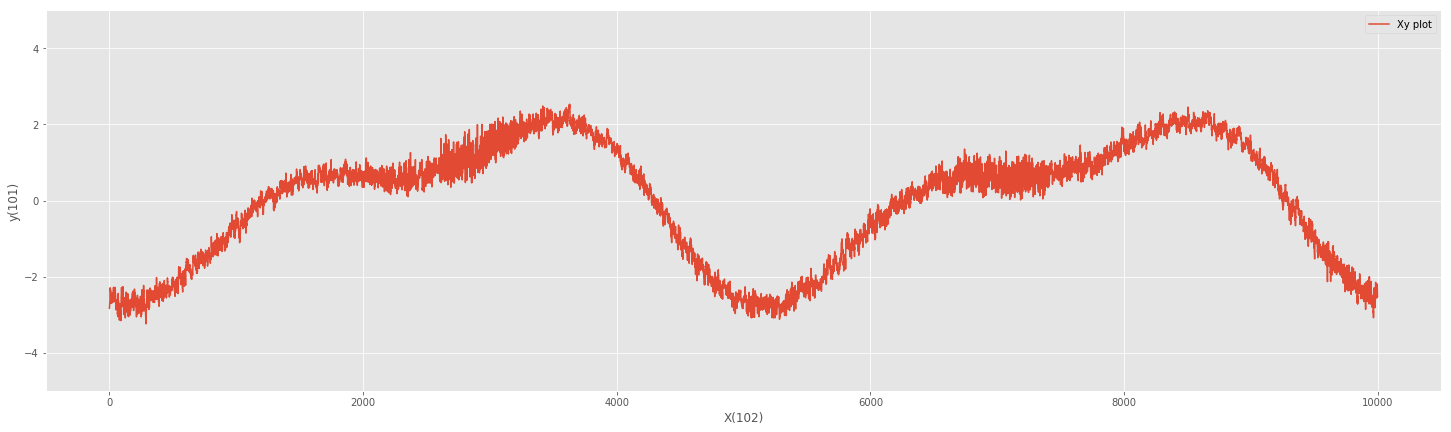

mse: 2.2966302184029557  abs max: 3.241541857910157  abs avg: 1.2928904496168518


In [300]:
show_performance_metrics(test_set_X_dnn, test_set_y_dnn, save_path)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import itertools
% matplotlib inline


class PerfMatrics():
    def __init__(self, y_actual, X, model, class_labels=None):
        self.y_actual = y_actual
        self.model = model
        self.X = X
        
        self.y_predict = self.model.predict(X)
        self.y_predict_proba = self.model.predict_proba(X)[:, 1]
        
        self.class_labels = class_labels
        self.conf_matrix = confusion_matrix(self.y_actual, self.y_predict)
        self.tn, self.fp, self.fn, self.tp = self.conf_matrix.ravel()

    def print_all_matrics(self):
        self._print_accuracy()
        self._print_recall()
        self._print_classification_report(self.y_actual, self.y_predict, self.class_labels)

        plt.rcParams["figure.figsize"] = (11,5)
        
        plt.subplot(1,2,1)
        self._plot_confusion_matrix(self.conf_matrix, self.class_labels)

        if self.y_predict_proba is not None:
            plt.subplot(1,2,2)
            self._plot_roc_curve()
        
        plt.tight_layout()  # automatically adjust params of subplot, https://matplotlib.org/users/tight_layout_guide.html

    def _plot_confusion_matrix(self, cm, classes,
                               normalize=False,
                               title='Confusion matrix',
                               cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        print('---------Confusion matrix and ROC Curve---------')
        '''
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)
        '''

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        print('')

    def _print_classification_report(self, y_actual, y_predict, class_labels=None):
        print('---------Classification report---------')
        print(classification_report(y_actual, y_predict, target_names=class_labels))
        print('')

    def _print_accuracy(self):
        print('---------Accuracy---------')
        accuracy = (self.tp + self.tn) / (self.tn + self.fp + self.fn + self.tp)
        print(accuracy)
        print('')

    def _print_recall(self):
        print('---------Recall---------')
        recall = recall_score(self.y_actual, self.y_predict)
        print(recall)
        print('')

    def _plot_roc_curve(self):
        # print('---------ROC Curve---------')
        fpr, tpr, thresholds = roc_curve(self.y_actual, self.y_predict_proba, pos_label=1)
        plt.plot(fpr, tpr)
        plt.ylabel('TPR')
        plt.xlabel('FPR')
        
        print('')

In [ ]:
class NNBCM:
    """
    Neural Network Binary Classification Model
    to be used for PrefMatrics class
    
    Binary target variable's name should be 'y_proba'
    """
    def __init__(self, save_path):
        self.save_path = save_path
        
    def predict(self, X_data):
        with tf.Session() as tf_sess:
            tf.train.Saver().restore(tf_sess, self.save_path)
            y_predict = tf_sess.run(y_pred, feed_dict={X:X_data})
            return y_predict.reshape(-1)  # reshape to rank-1 array
    
    def predict_proba(self, X_data):
        with tf.Session() as tf_sess:
            tf.train.Saver().restore(tf_sess, self.save_path)
            _y_proba = tf_sess.run(y_proba, feed_dict={X:X_data})
            return _y_proba  # n by 2 matrix with 0-proba and 1-proba


In [306]:

feature_columns = [
    # "curb-weight" and "highway-mpg" are numeric columns.
    tf.feature_column.numeric_column(key="u"),
    tf.feature_column.numeric_column(key="v"),
    tf.feature_column.numeric_column(key="w")
]

# Build the Estimator.
model = tf.estimator.LinearRegressor(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\moon\\AppData\\Local\\Temp\\tmpoj0g55e9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000187A7FF7240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [318]:
STEPS = 100
# Train the model.
# By default, the Estimators log output every 100 steps.
model.train(input_fn=input_train, steps=STEPS)

INFO:tensorflow:Calling model_fn.


ValueError: You must provide a labels Tensor. Given: None. Suggested troubleshooting steps: Check that your data contain your label feature. Check that your input_fn properly parses and returns labels.

In [ ]:
# Evaluate how the model performs on data it has not yet seen.
eval_result = model.evaluate(input_fn=input_test)

In [316]:
def input_train():
    return {'u':tf.convert_to_tensor(training_set_X[:,0], np.float32), 'v':tf.convert_to_tensor(training_set_X[:,1], np.float32), 'w':tf.convert_to_tensor(training_set_X[:,2], np.float32)}

In [317]:
input_train()

{'u': <tf.Tensor 'Const_2:0' shape=(15000,) dtype=float32>,
 'v': <tf.Tensor 'Const_3:0' shape=(15000,) dtype=float32>,
 'w': <tf.Tensor 'Const_4:0' shape=(15000,) dtype=float32>}

<tf.Tensor 'Const_1:0' shape=(15000,) dtype=float32>

> - https://www.tensorflow.org/versions/r1.1/tutorials/wide

In [352]:
import tensorflow as tf


feature_names = ['u', 'v', 'w']
label_name = 'y'

def input_fn(df):

    feature_cols = {k: tf.constant(df[k].values) for k in feature_names}

    label = tf.constant(df[label_name].values)
    
    return feature_cols, label

In [359]:
feature_names = ['c'+str(k) for k in range(training_set_X_poly_reg.shape[1])] + ['y']
feature_columns = [tf.feature_column.numeric_column(k) for k in feature_names]
regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns)

df_tr = pd.DataFrame(data=np.concatenate((training_set_X_poly_reg, training_set_y), axis=1), columns=feature_names)
df_ts = pd.DataFrame(data=np.concatenate((test_set_X_poly_reg, test_set_y), axis=1), columns=feature_names)
# training_set_y

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\moon\\AppData\\Local\\Temp\\tmpwbxs69su', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000187A9D412B0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [360]:
regressor.train(input_fn=lambda: input_fn(df_tr), steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\moon\AppData\Local\Temp\tmpwbxs69su\model.ckpt.
INFO:tensorflow:loss = 67178800.0, step = 1
INFO:tensorflow:global_step/sec: 243.463
INFO:tensorflow:loss = 5630.8994, step = 101 (0.413 sec)
INFO:tensorflow:global_step/sec: 564.43
INFO:tensorflow:loss = 5436.632, step = 201 (0.176 sec)
INFO:tensorflow:global_step/sec: 551.995
INFO:tensorflow:loss = 5250.4365, step = 301 (0.181 sec)
INFO:tensorflow:global_step/sec: 511.609
INFO:tensorflow:loss = 5071.968, step = 401 (0.195 sec)
INFO:tensorflow:global_step/sec: 511.153
INFO:tensorflow:loss = 4900.9673, step = 501 (0.196 sec)
INFO:tensorflow:global_step/sec: 545.973
INFO:tensorflow:loss = 4737.0527, step = 601 (0.184 sec)
INFO:tensorflow:global_step/sec

In [ ]:
regressor.evaluate(input_fn=lambda: input_fn(df_ts))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-28-14:12:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\moon\AppData\Local\Temp\tmpwbxs69su\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
